In [9]:
!pip install pyserial
!pip install pynmea2
!pip install geopandas
!pip install contextily

# Save NMEA data from GPS receiver to file

In [2]:
# you need to connect GPS receiver to USB to run following code

# import serial
# import datetime

# ser = serial.Serial("/dev/cu.usbserial-0001", baudrate=9600)
# ser.flushInput()
# ser.flushOutput()
# idx = 0

# nmea_data = b""

# # skip first line, since it could be incomplete
# ser.readline()

# while True:
#     idx += 1
#     nmea_sentence = ser.readline()
#     nmea_data += nmea_sentence

#     if idx % 100 == 0:
#         print(f"idx: {idx}")
        
#     if idx % 2000 == 0:

#         # save to file after 2000 sentences added
#         filename = datetime.datetime.utcnow().strftime("data/gps_data_%Y%m%d-%H%M%S.nmea")
#         f = open(filename, "ab")
#         f.write(nmea_data)
#         f.close()
        
#         nmea_data = b""

# Download example NMEA data

In [3]:
import requests
import os

response = requests.get("https://raw.githubusercontent.com/maxim75/data-visualization/master/notebooks/data/geo/gps_data_20220215-070028.nmea")

if not os.path.exists("data"):
    os.makedirs("data")
f = open("data/gps_data.nmea", "a")
f.write(response.text)
f.close()


# Show first 10 message properties

In [4]:
import pynmea2

nmea_data = open("data/gps_data.nmea", "rb")
for message_bytes in nmea_data.readlines()[:10]: # read first 10 messages from file
    try:
        message = message_bytes.decode("utf-8").replace("\n", "").replace("\r", "")
        parsed_message = pynmea2.parse(message)
    except:
        # skip invalid messages
        continue
        
    print(f"message: {message}")

    for field in parsed_message.fields:
        value = getattr(parsed_message, field[1])
        print(f"{field[0]:40} {field[1]:20} {value}")
    
    print("\n")

message: $GNGSA,A,3,21,22,01,31,32,10,03,04,,,,,1.27,0.69,1.06*17
Mode                                     mode                 A
Mode fix type                            mode_fix_type        3
SV ID01                                  sv_id01              21
SV ID02                                  sv_id02              22
SV ID03                                  sv_id03              01
SV ID04                                  sv_id04              31
SV ID05                                  sv_id05              32
SV ID06                                  sv_id06              10
SV ID07                                  sv_id07              03
SV ID08                                  sv_id08              04
SV ID09                                  sv_id09              
SV ID10                                  sv_id10              
SV ID11                                  sv_id11              
SV ID12                                  sv_id12              
PDOP (Dilution of precision)      

# Extract data from parsed messages

In [5]:
import pynmea2

nmea_data = open("data/gps_data.nmea", "rb")

coordinates_data = []

for message_bytes in nmea_data.readlines():    
    try:
        message = message_bytes.decode("utf-8").replace("\n", "").replace("\r", "")
        parsed_message = pynmea2.parse(message)
    except:
        # skip invalid sentences
        continue

    cga_data = {}
    
    # process only GGA messages
    if parsed_message.sentence_type == "GGA":
        for attr in ["timestamp", "latitude", "longitude", "latitude", "horizontal_dil", "num_sats", "gps_qual"]:
            cga_data[attr] = getattr(parsed_message, attr)
        coordinates_data.append(cga_data)
        
coordinates_data[0]
        

{'timestamp': datetime.time(6, 46, 55),
 'latitude': -34.048630333333335,
 'longitude': 151.02375633333332,
 'horizontal_dil': '0.62',
 'num_sats': '12',
 'gps_qual': 1}

# Create geo data frame

In [6]:
import pandas as pd
import geopandas as gpd

df = pd.DataFrame(coordinates_data)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
gdf

/Users/z/code/data-visualization/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


,timestamp,latitude,longitude,horizontal_dil,num_sats,gps_qual,geometry
0,06:46:55,-34.048630,151.023756,0.62,12,1,POINT (151.02376 -34.04863)
1,06:46:56,-34.048630,151.023757,0.62,12,1,POINT (151.02376 -34.04863)
2,06:46:57,-34.048623,151.023758,0.62,12,1,POINT (151.02376 -34.04862)
3,06:46:58,-34.048609,151.023757,0.61,12,1,POINT (151.02376 -34.04861)
4,06:46:59,-34.048588,151.023755,0.62,12,1,POINT (151.02376 -34.04859)
...,...,...,...,...,...,...,...
1623,07:00:24,-34.047688,151.022902,0.66,12,1,POINT (151.02290 -34.04769)
1624,07:00:25,-34.047663,151.023005,0.66,12,1,POINT (151.02301 -34.04766)
1625,07:00:26,-34.047636,151.023108,0.66,12,1,POINT (151.02311 -34.04764)
1626,07:00:27,-34.047610,151.023211,0.66,12,1,POINT (151.02321 -34.04761)


# Render map 

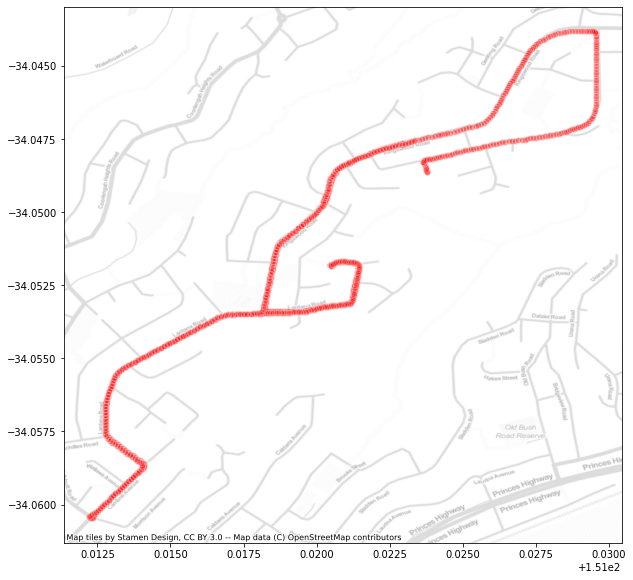

In [7]:
import matplotlib.pyplot as plt
import contextily as ctx

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
gdf[gdf.gps_qual > 0].plot(ax=ax, alpha=.2, edgecolor="#ffff", color='red')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs="EPSG:4326", alpha=.3)